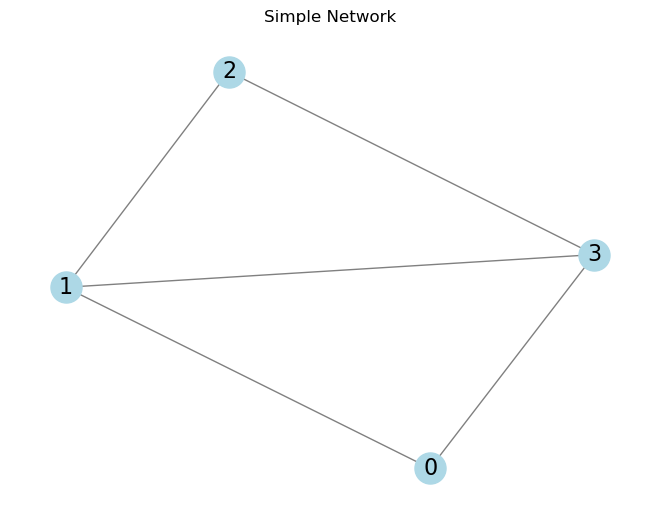

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to create a simple network
def create_network():
    G = nx.Graph()
    edges = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 3)]  # Define the edges
    G.add_edges_from(edges)  # Add the edges to the network
    return G

# Create the network
G = create_network()

# Visualize the network
def visualize_network(G):
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
    plt.title("Simple Network")
    plt.show()

# Visualize the network
visualize_network(G)

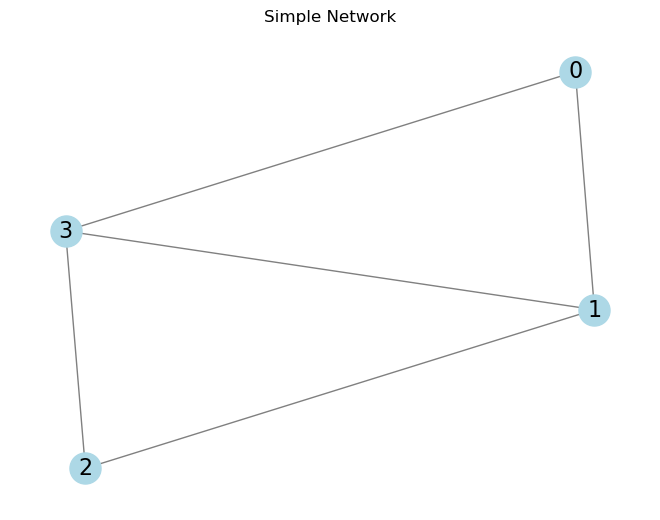

Estimated R_{N_A} for the created network: 4.9042321045820364e-71


In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import random

# Compute link counts between groups
def compute_link_counts(A, P):
    """Compute the number of links between groups in partition P."""
    n_groups = len(P)
    l_alpha_beta = np.zeros((n_groups, n_groups))
    for i in range(n_groups):
        for j in range(n_groups):
            l_alpha_beta[i, j] = len(list(nx.edge_boundary(A, P[i], P[j])))
    return l_alpha_beta

# Compute r_alpha_beta values
def compute_r_values(l_alpha_beta, l_O_alpha_beta):
    """Compute r_alpha_beta values."""
    return l_alpha_beta / (l_O_alpha_beta + 1e-10)  # Avoid division by zero

# Function h(A; A_O, P)
def h_function(A, A_O, P):
    """Compute the function h(A; A_O, P)."""
    eps = 1e-10  # Small constant to prevent division by zero

    l_alpha_beta = compute_link_counts(A, P)
    l_O_alpha_beta = compute_link_counts(A_O, P)
    r_alpha_beta = compute_r_values(l_alpha_beta, l_O_alpha_beta)

    # Ensure no division by zero
    log_terms = np.log((r_alpha_beta + eps) / (2 * r_alpha_beta + 1 + eps)) + \
                np.log((r_alpha_beta * l_O_alpha_beta + eps) / (2 * r_alpha_beta * l_alpha_beta + l_O_alpha_beta + eps))
    
    return np.exp(np.sum(log_terms))

# Hamiltonian Function
def hamiltonian(P, G):
    """
    Compute the Hamiltonian for a given partition P of graph G.

    Parameters:
    P : list of sets
        A partition of nodes, where each set represents a community.
    G : networkx.Graph
        The original graph.

    Returns:
    float
        The Hamiltonian value for the given partition.
    """
    # Convert partition into a dictionary mapping node to its community
    community_map = {node: i for i, community in enumerate(P) for node in community}
    
    # Initialize r and lO
    r = {}
    lO = {}
    
    # Compute observed link counts r_alpha_beta
    for u, v in G.edges():
        c_u, c_v = community_map[u], community_map[v]
        if c_u > c_v:  # Ensure consistent ordering
            c_u, c_v = c_v, c_u
        r[(c_u, c_v)] = r.get((c_u, c_v), 0) + 1
    
    # Compute expected link counts lO_alpha_beta using degree product
    m = G.number_of_edges()
    degrees = dict(G.degree())
    
    for (c_u, c_v) in r.keys():
        sum_deg_u = sum(degrees[node] for node in P[c_u])
        sum_deg_v = sum(degrees[node] for node in P[c_v])
        expected_links = (sum_deg_u * sum_deg_v) / (2 * m)
        lO[(c_u, c_v)] = max(expected_links, 1e-10)  # Avoid division by zero
    
    # Compute the Hamiltonian sum
    H = sum(np.log(r_ij + 1) + np.log(r_ij / lO[(c_u, c_v)])
            for (c_u, c_v), r_ij in r.items())
    
    return H

# Function to propose a new network by randomly adding/removing an edge
def propose_new_network(G, frac=0.1):  # Reduce fraction of edges changed
    """Propose a new network by slightly modifying edges."""
    new_G = G.copy()
    
    edges = list(new_G.edges)
    non_edges = list(nx.non_edges(new_G))

    if len(edges) == 0 or len(non_edges) == 0:
        return new_G  # Avoid breaking the network if no edges can be changed

    # Reduce the number of edges to alter
    num_alter = max(1, int(len(edges) * frac))

    # Remove fewer edges
    edges_to_remove = random.sample(edges, min(num_alter, len(edges)))
    new_G.remove_edges_from(edges_to_remove)

    # Add fewer new edges
    edges_to_add = random.sample(non_edges, min(num_alter, len(non_edges)))
    new_G.add_edges_from(edges_to_add)

    return new_G

# Metropolis algorithm to estimate R_{N_A}
def metropolis_algorithm(A_O, partition_A, n_iter=1000):
    """Estimate R_{N_A} using the Metropolis algorithm."""
    A = A_O.copy()
    R_NA = 0
    
    for _ in range(n_iter):
        # Propose a new network A_new
        A_new = propose_new_network(A)
        
        # Compute the acceptance probability
        delta_H = hamiltonian(partition_A, A_new) - hamiltonian(partition_A, A)
        acceptance_prob = min(1, np.exp(-delta_H))
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            A = A_new
        
        # Update R_{N_A}
        R_NA += h_function(A, A_O, partition_A)
    
    return R_NA / n_iter

# Create the fixed network
G = create_network()

# Define the partition (each node is its own group)
partition_G = [{node} for node in G.nodes]

# Visualize the network
visualize_network(G)

# Estimate R_{N_A} using the created network
R_NA = metropolis_algorithm(G, partition_G)
print(f"Estimated R_{{N_A}} for the created network: {R_NA}")


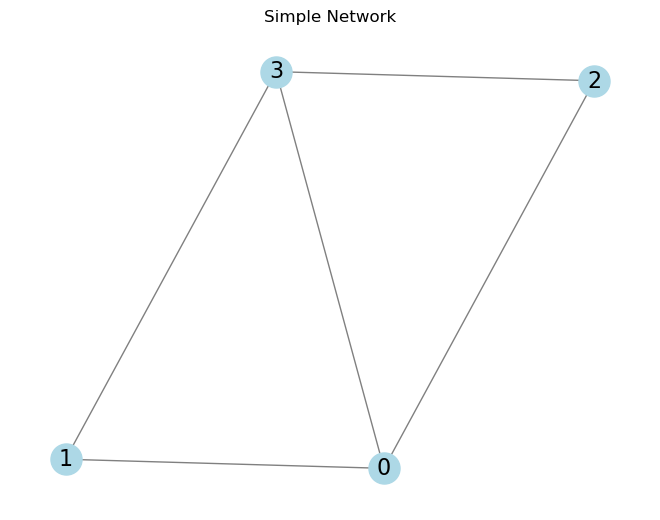

In [5]:
G_new = propose_new_network(G)

visualize_network(G_new)